In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy

    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import gc
gc.collect()  #

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Zamuro_DataLoader import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import pacmap

import warnings
warnings.filterwarnings("ignore")


import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

In [3]:
audios = pd.read_csv(f"Complementary_Files/zamuro_audios_complete.csv", index_col=0)
recorders = pd.read_csv(f"Complementary_Files/zamuro_recorders_satelites.csv", index_col=0)
df_ae = pd.read_csv(f"temporal_zamuro/Features/New_df_ae_unflat.csv")
X = np.asarray(df_ae.loc[:,"0":"25919"])
X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
X = np.mean(X, axis=1)
print(X.shape)

(53275, 5184)


In [4]:
PCA_ = PCA(n_components=60).fit(X)
X_PCA = PCA_.transform(X)

In [5]:
Normalizer_ = Normalizer().fit(X_PCA)
X_norm = Normalizer_.transform(X_PCA)

scaler = StandardScaler().fit(X_PCA)
X_scaled = scaler.transform(X_PCA)

In [21]:
X_p = np.reshape(X, X.shape[0]*X.shape[1])
X_n = np.reshape(X_norm, X_norm.shape[0]*X_norm.shape[1])
X_s = np.reshape(X_scaled, X_scaled.shape[0]*X_scaled.shape[1])

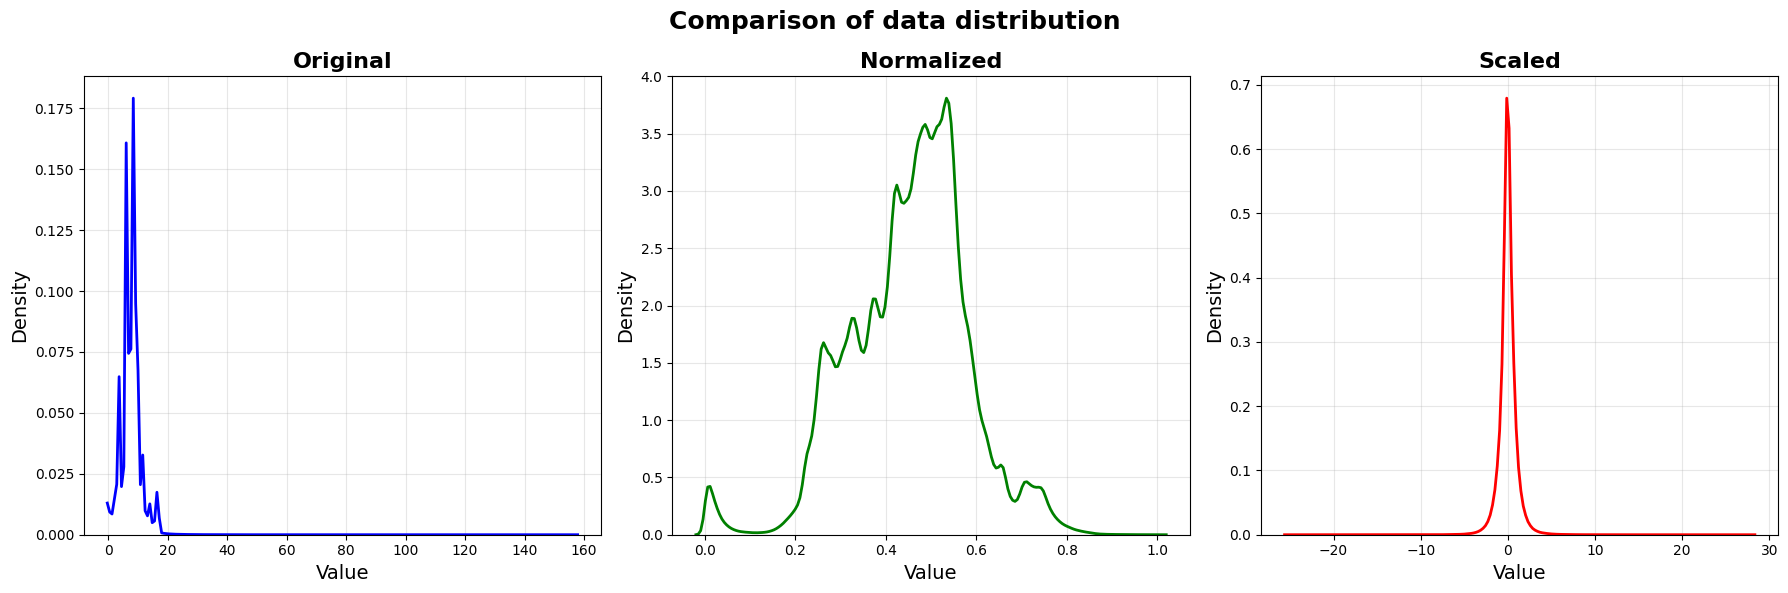

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear figura con 3 subgráficos en fila
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Colores y nombres para cada gráfico
data = [(X_p, "Original", 'blue'), 
        (X_n, "Normalized", 'green'), 
        (X_s, "Scaled", 'red')]

# Generar los KDE plots en cada subplot
for ax, (X, title, color) in zip(axes, data):
    sns.kdeplot(X, color=color, linewidth=2, ax=ax)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Value", fontsize=14)
    ax.set_ylabel("Density", fontsize=14)
    ax.grid(alpha=0.3)  # Suaviza el grid
plt.suptitle("Comparison of data distribution", fontsize=18, fontweight='bold')
plt.tight_layout()

plt.savefig("temporal_zamuro/distplots.PDF", format="PDF", bbox_inches="tight")

plt.show()
